# Demo Run

In [1]:
import os
import sys
import warnings
import anndata as ad
import scanpy as sc
from pathlib import Path

sys.path.append(str(Path(os.getcwd()).resolve().parents[0]))

In [2]:
import tardis

local_run = True
if local_run:
    tardis.config = tardis.config_local
else:
    tardis.config = tardis.config_server

In [3]:
adata_file_path = os.path.join(tardis.config.io_directories["processed"], "dataset_subset_sample_status_1.h5ad")
assert os.path.isfile(adata_file_path), f"File not already exist: `{adata_file_path}`"
metadata_of_interest = "sample_status"

In [4]:
adata = ad.read_h5ad(adata_file_path)
adata

AnnData object with n_obs × n_vars = 11279 × 4096
    obs: 'handle_anndata', 'study', 'sample_ID', 'organ', 'age', 'cell_type', 'lane_ID', 'author_batch', 'institute', 'study_PI', 'doi', 'integration_donor', 'integration_biological_unit', 'integration_sample_status', 'integration_library_platform_coarse', 'anatomical_region', 'anatomical_region_level_2', 'sex', 'sex_inferred', 'subject_type', 'sample_status', 'sample_cultured', 'protocol_tissue_dissociation', 'cell_enrichment', 'library_platform', 'strand_sequence', 'sequencing_platform', 'reads_processing', 'biological_unit', 'reference_genome', 'reference_genome_ensembl_release', 'concatenated_integration_covariates'
    var: 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'highly_variable', 'hvg', 'log1p', 'unification'

## Training

In [5]:
model_params = dict(
    n_hidden=512,
    n_layers=3, 
    n_latent=20, 
    gene_likelihood="nb",
    dropout_rate = 0.1
)
train_params = dict(
    max_epochs=10
)
dataset_params = dict(
    layer=None, 
    batch_key="concatenated_integration_covariates"
)

In [6]:
tardis.MyModel.setup_anndata(adata, **dataset_params)

In [7]:
tardis.MyModel.setup_wandb(
    wandb_configurations=tardis.config_local.wandb,
    hyperparams=dict(
        model_params=model_params,
        train_params=train_params,
        dataset_params=dataset_params,
    )
)

In [8]:
vae = tardis.MyModel(adata, **model_params)

In [9]:
vae.train(**train_params)

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/kemalinecik/tools/apps/mamba/envs/tardis_env/lib/python3.10/site-packages/lightning/pytorch/trainer/setup.py:201: MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Epoch 10/10: 100%|██████████| 10/10 [00:34<00:00,  3.48s/it, v_num=x0_1, train_loss_step=256, train_loss_epoch=237]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 10/10: 100%|██████████| 10/10 [00:34<00:00,  3.49s/it, v_num=x0_1, train_loss_step=256, train_loss_epoch=237]


## Visualization

In [5]:
adata.obsm["X_scVI"] = vae.get_latent_representation()
sc.pp.neighbors(adata, n_neighbors = 30, use_rep="X_scVI")
sc.tl.umap(adata, min_dist=0.2)

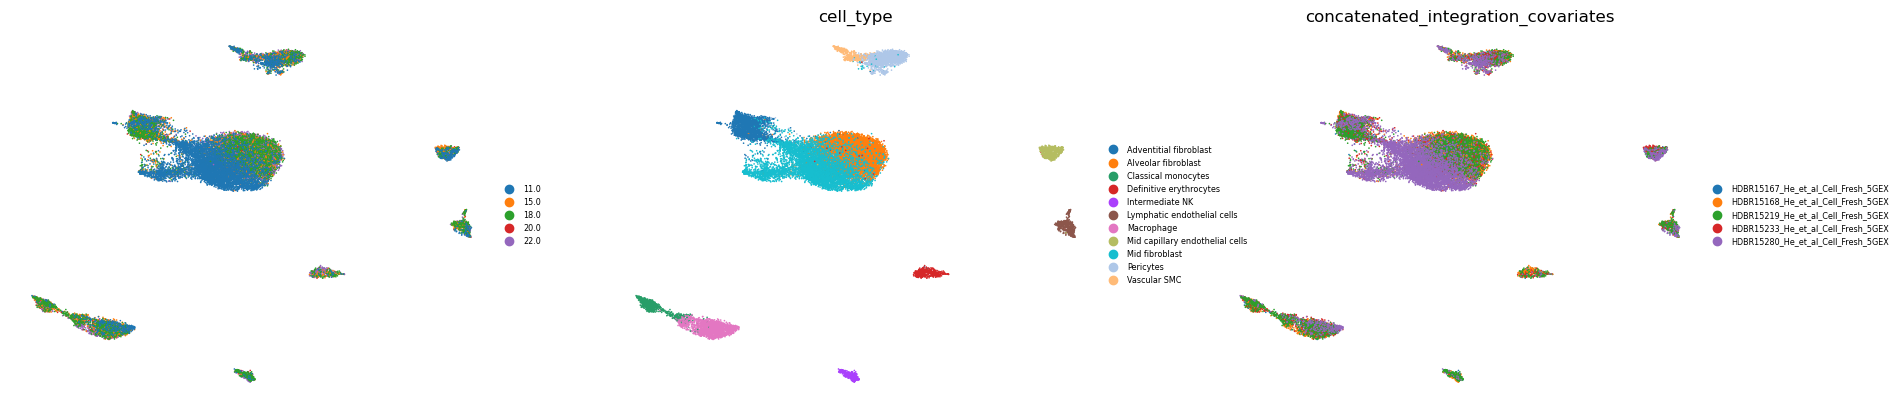

In [6]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    sc.pl.umap(
        adata, 
        color=[metadata_of_interest, "cell_type", "concatenated_integration_covariates"], 
        ncols=3,
        frameon=False,
        title="",
        legend_fontsize="xx-small"
    )